In [9]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
from matplotlib import pyplot as plt

In [3]:
epochs = 25
batch_size = 32

In [4]:
file_directory = "/content/drive/MyDrive/Colab Notebooks/Save"

# Chargement des données d'entrainement
train_dataset = image_dataset_from_directory(
    file_directory,
    validation_split=0.2,  # 30% pour la validation
    subset="training",
    seed=123,
    image_size=(200, 200),
    batch_size=batch_size
)

# Chargement des donénes de validation
validation_dataset = image_dataset_from_directory(
    file_directory,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(200, 200),
    batch_size=batch_size
)

Found 3269 files belonging to 6 classes.
Using 2616 files for training.
Found 3269 files belonging to 6 classes.
Using 653 files for validation.


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
# Normalisation des images
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

# permet de d'éviter le surapprentissage
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.01,
                               patience=10, # nombre de cycle à attendre si pas d'amélioration avant de terminer l'entrainement
                               verbose=1,
                               mode='min')

# Sauvegarde le meilleur meilleur modèle renconré pendant l'entrainement
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/model_IA.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='min')

callbacks=[early_stopping, model_checkpoint]


#model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 99, 99, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 64)        0

In [8]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/25
82/82 [==============================] - ETA: 0s - loss: 1.1846 - accuracy: 0.5684
Epoch 1: val_loss improved from inf to 0.40155, saving model to /content/drive/MyDrive/Colab Notebooks/model_IA.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


82/82 [==============================] - 276s 2s/step - loss: 1.1846 - accuracy: 0.5684 - val_loss: 0.4015 - val_accuracy: 0.9265
Epoch 2/25
82/82 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9335
Epoch 2: val_loss improved from 0.40155 to 0.08683, saving model to /content/drive/MyDrive/Colab Notebooks/model_IA.h5
82/82 [==============================] - 8s 95ms/step - loss: 0.1833 - accuracy: 0.9335 - val_loss: 0.0868 - val_accuracy: 0.9755
Epoch 3/25
82/82 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9805
Epoch 3: val_loss improved from 0.08683 to 0.07751, saving model to /content/drive/MyDrive/Colab Notebooks/model_IA.h5
82/82 [==============================] - 8s 94ms/step - loss: 0.0536 - accuracy: 0.9805 - val_loss: 0.0775 - val_accuracy: 0.9755
Epoch 4/25
82/82 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9851
Epoch 4: val_loss improved from 0.07751 to 0.02602, saving model to /content/drive/MyDrive

In [12]:
print(history.history)

{'loss': [1.1846418380737305, 0.1833042949438095, 0.05364295095205307, 0.03978293389081955, 0.019808070734143257, 0.013862109743058681, 0.01626971736550331, 0.017970867455005646, 0.03565901145339012, 0.02160274237394333, 0.006619287189096212, 0.003149503143504262, 0.018665596842765808, 0.007826932705938816, 0.011207915842533112, 0.002727048471570015], 'accuracy': [0.5684250593185425, 0.9334862232208252, 0.98050457239151, 0.9850917458534241, 0.9938837885856628, 0.9950305819511414, 0.9961773753166199, 0.9931192398071289, 0.9877675771713257, 0.9923547506332397, 0.997706413269043, 0.9988532066345215, 0.9938837885856628, 0.9973241686820984, 0.9961773753166199, 0.9992354512214661], 'val_loss': [0.40154722332954407, 0.08682727068662643, 0.07751419395208359, 0.026017941534519196, 0.018811220303177834, 0.007592474110424519, 0.029904775321483612, 0.013742804527282715, 0.056945182383060455, 0.029408195987343788, 0.005216303747147322, 0.0014487608568742871, 0.0032535414211452007, 0.009130713529884

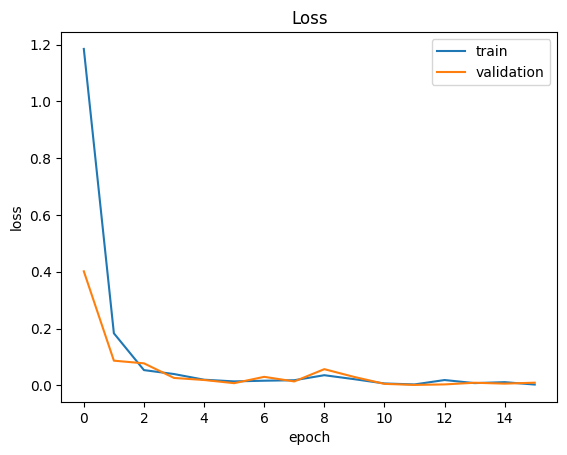

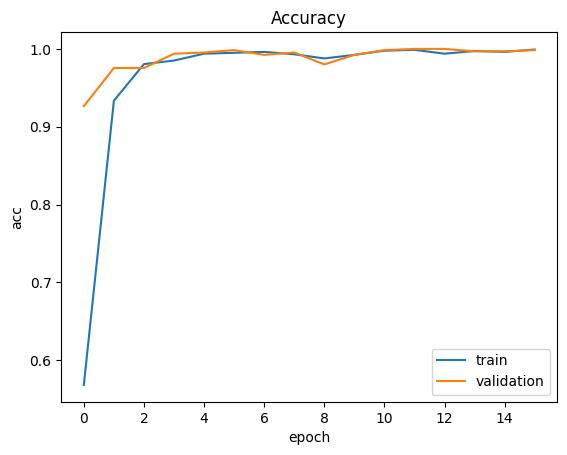

In [14]:
plt.subplot(1, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()

plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train', 'validation'])
plt.show()